https://stackoverflow.com/questions/34975972/how-can-i-make-a-video-from-array-of-images-in-matplotlib

In [1]:
# Complicated way to import finis if not installed

import os
import sys
finis_path = "../tp" #Folder containing finis folder
finis_abs_path = os.path.abspath(finis_path)
sys.path.append(finis_abs_path)

import finis
import numpy as np
import scipy.sparse as sp
import scipy
import pyamg
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy.integrate import ode, solve_ivp
from scipy.optimize import approx_fprime


%matplotlib inline

In [2]:
%matplotlib inline

### Question 12: Setup

DOF: 3501


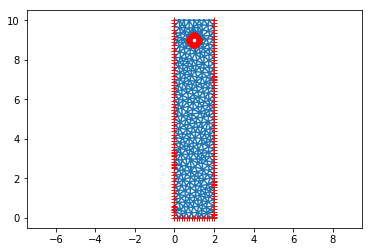

In [41]:
mx = 1
my = 9
max_area = 0.05
mesh = finis.triangulate(geom='project', max_area=max_area, mx=mx, my=my, n=40)
fe_u = finis.fe_space(mesh, order=2, order_int=2)
fe_p = finis.fe_space(mesh, order=1, order_int=2)
finis.plot_mesh(mesh, fig=plt.figure())

if True:
    markers = fe_u['markers']
    free_upper_boundary = True

    if free_upper_boundary:
        markers = np.logical_and(markers, np.logical_or(fe_u['dof'][:,1] < 10.0, np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)))
    plt.plot(fe_u['dof'][markers==1,0], fe_u['dof'][markers==1,1], 'r+')
    plt.axis("equal")


assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"

print("DOF: {}".format(fe_u['dof'].shape[0]*2 + fe_p['dof'].shape[0]))

### Define functions

In [4]:
def fem_solve(mx, my, vx, vy, jac=False):
    mesh = finis.triangulate(geom='project', max_area=max_area, mx=mx, my=my, n=40)
    fe_u = finis.fe_space(mesh, order=2, order_int=2)
    fe_p = finis.fe_space(mesh, order=1, order_int=2)
    
    dim_u = fe_u['dof'].shape[0]
    dim_p = fe_p['dof'].shape[0]
    
    assert np.array_equal(fe_u['integ'], fe_p['integ']), "FE Spaces not compatible"
    assert np.array_equal(fe_u['w'], fe_p['w']), "FE integration weights not compatible"
    
    # Free upper boundary
    markers = fe_u['markers']
    h_bnd = np.logical_or(fe_u['dof'][:,0] == 0, fe_u['dof'][:,0] == 2)
    not_top_bnd = fe_u['dof'][:,1] < 10.0
    markers = np.logical_and(markers, np.logical_or(h_bnd, not_top_bnd))
    
    min_dist = min([mx, 2-mx, my, 10-my])
    
    # Setting up system
    f1 = lambda x,y: np.zeros_like(x)
    f2 = lambda x,y: -9.81*np.ones_like(x)
    
    # Particular solution
    r2_dof = (fe_u['dof'][:,0]-mx)**2 + (fe_u['dof'][:,1]-my)**2
    markers_circle = np.logical_and(markers, r2_dof <= (0.25+1e-6)**2)
    w_h = np.zeros((dim_u, ))
    w_h[markers_circle] = 1
    UP1 = np.zeros((dim_u, ))
    UP2 = np.zeros((dim_u, ))
    UP1[markers_circle] = vx
    UP2[markers_circle] = vy
    UHP = np.concatenate((UP1, UP2, np.zeros((dim_p, ))))        
    
    # Construct non-dirichlet RHS
    W = sp.spdiags(fe_u['w'], [0], m=fe_u['w'].size, n=fe_u['w'].size)
    A11 = fe_u['DUX'].transpose().dot(W).dot(fe_u['DUX']) + fe_u['DUY'].transpose().dot(W).dot(fe_u['DUY'])
    A22 = A11
    A12 = fe_u['DUY'].transpose().dot(W).dot(fe_u['DUX'])
    A21 = A12.transpose()
    A13 = -fe_u['DUX'].transpose().dot(W).dot(fe_p['U'])
    A23 = -fe_u['DUY'].transpose().dot(W).dot(fe_p['U'])
    A = sp.bmat([[A11, A12, A13], [A21, A22, A23], [A13.transpose(), A23.transpose(), None]], format='csr')
    assert np.allclose((A - A.transpose()).data, 0), "A is not numerically symmetric!"
    
    # Construct non-dirichlet LHS
    F1int = f1(fe_u['integ'][:,0], fe_u['integ'][:,1])
    F2int = f2(fe_u['integ'][:,0], fe_u['integ'][:,1])

    _F1 = np.concatenate((
        fe_u['U'].transpose().dot(W).dot(F1int),
        fe_u['U'].transpose().dot(W).dot(F2int),
        np.zeros(dim_p, )
    ))
    F = _F1 - A.dot(UHP)
    
    # Apply dirichlet boundary
    row = np.where(markers==0)[0]
    col = np.arange(row.size)
    data = np.ones((row.size, ), dtype=np.float)
    P_u = sp.csr_matrix((data, (row, col)), shape=(markers.size, row.size))
    dim_ud = P_u.shape[1]
    P = sp.bmat([[P_u, None, None], [None, P_u, None], [None, None, sp.eye(dim_p)]], format='csr')
    Ad = P.transpose().dot(A).dot(P)
    assert np.allclose((Ad - Ad.transpose()).data, 0), "Ad is not numerically symmetric!"
    Fd = P.transpose().dot(F)
    
    # Solve
    x = sp.linalg.spsolve(Ad, Fd)
    # x[2*dim_ud:] -= np.mean(x[2*dim_ud:]) # remove mean pressure
    
    # Transform back (Dirichlet)
    u_h = P.dot(x) + UHP
    u1_h = u_h[0:dim_u]
    u2_h = u_h[dim_u:2*dim_u]
    p_h = u_h[2*dim_u:]
    assert p_h.size == dim_p
    
    # Calculate Viscos force
    Fb_x = sp.bmat([[A11], [A21], [A13.transpose()]], format='csr').dot(w_h).dot(u_h)
    Fb_y = sp.bmat([[A12], [A22], [A23.transpose()]], format='csr').dot(w_h).dot(u_h)
    
    if jac:
        # Calculate Jacobian
        # By theory we know that d/dx = d/dy = 0
        # Only calculate d/dvx, d/dvy
        S = np.zeros((2*dim_u+dim_p, 2), dtype=np.float)
        S[0:dim_u, 0] = w_h
        S[dim_u:2*dim_u, 1] = w_h
        _tmp1 = P.transpose().dot(A.dot(S))
        _tmp2 = - P.dot(sp.linalg.spsolve(Ad, _tmp1)) + S
        _tmp3_1 = sp.bmat([[A11], [A21], [A13.transpose()]], format='csr').dot(w_h).dot(_tmp2)
        _tmp3_2 = sp.bmat([[A12], [A22], [A23.transpose()]], format='csr').dot(w_h).dot(_tmp2)
        
        jac = np.zeros((2, 4), dtype=np.float)
        jac[0, 2:4] = _tmp3_1
        jac[1, 2:4] = _tmp3_2
        
        return fe_u, fe_p, u1_h, u2_h, p_h, Fb_x, Fb_y, jac

    return fe_u, fe_p, u1_h, u2_h, p_h, Fb_x, Fb_y

def fem_plot(fe_u, fe_p, u1_h, u2_h, p_h):
    shading= 'flat' # flat or gouraud
    max_u = max([
        np.amax(u1_h),
        np.amax(u2_h),
    ])
    min_u = min([
        np.amin(u1_h),
        np.amin(u2_h),
    ])

    fig = plt.figure(figsize=(9,5))
    ax = fig.add_subplot(1, 3, 1)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1_h, shading=shading, vmin=min_u, vmax=max_u)
    ax.set_title("U_x")
    ax.set_xlabel("x")
    plt.colorbar()

    fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading=shading, vmin=min_u, vmax=max_u)
    plt.title("U_y")
    plt.xlabel("x")
    plt.colorbar()

    ax = fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
    plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading)
    plt.title("P")
    plt.xlabel("x")
    plt.colorbar()

    plt.tight_layout()
    plt.show()
    
def fem_rhs(t, y, m, debug=False):
    """y = [pos_x1, pos_x2, vel_x1, vel_x2]"""
    if debug:
        print("fem_rhs: t = {}, y = {}".format(t, y))
    fe_u, fe_p, u1_h, u2_h, p_h, Fb_x, Fb_y = fem_solve(y[0], y[1], y[2], y[3])
    a1 = (- Fb_x) / m
    a2 = (- Fb_y - 9.81*m) / m
    
    dy = np.array([y[2], y[3], a1, a2])
    return dy

def fem_jac(t, y, m, debug=False):
    if debug:
        print("fem_jac: t = {}, y = {}".format(t, y))
    _, _, _, _, _, _, _, jac = fem_solve(y[0], y[1], y[2], y[3], jac=True)
    Jf = np.zeros((4,4), dtype=np.float)
    Jf[0,2] = 1
    Jf[1,3] = 1
    Jf[2:4,:] = -jac/m
    
    return Jf

def approx_jac(xk, f, epsilon=0.01):
    y = f(xk)
    n = y.size
    jac = np.zeros((n, xk.size), dtype=np.float)
    for i in range(n):
        f_loc = lambda x: f(x)[i]
        jac[i,:] = approx_fprime(xk, f_loc, epsilon)
        
    return jac

In [5]:
%%time
m = 1.0
f = lambda t, y: fem_rhs(t, y, m=m, debug=True)
jac = lambda t, y: fem_jac(t, y, m=m, debug=True)

tspan = np.array([0., 2])
y0 = np.array([1., 9, 0, 0])

sol = solve_ivp(f, tspan, y0, method='RK45', dense_output=True)
if sol.status < 0:
    print("Failed")
    print(sol.message)
else:
    print("Succeeded in {} steps with {} rhs calls".format(sol.t.size, sol.nfev))

fem_rhs: t = 0.0, y = [1. 9. 0. 0.]
fem_rhs: t = 1.8277779602175701e-06, y = [ 1.00000000e+00  9.00000000e+00 -1.76543982e-20 -1.41342874e-05]
fem_rhs: t = 3.65555592043514e-05, y = [ 1.00000000e+00  9.00000000e+00 -3.53087965e-19 -2.82685749e-04]
fem_rhs: t = 5.4833338806527106e-05, y = [ 1.00000000e+00  8.99999999e+00 -1.51936131e-11 -4.23833175e-04]
fem_rhs: t = 0.0001462222368174056, y = [ 1.00000000e+00  8.99999992e+00 -1.07782635e-10 -1.12935528e-03]
fem_rhs: t = 0.00016246915201933957, y = [ 1.00000000e+00  8.99999990e+00 -2.75963821e-10 -1.25466968e-03]
fem_rhs: t = 0.00018277779602175702, y = [ 1.00000000e+00  8.99999987e+00 -3.36873611e-11 -1.41126247e-03]
fem_rhs: t = 0.00018277779602175702, y = [ 1.00000000e+00  8.99999987e+00  1.21223055e-10 -1.41119587e-03]
fem_rhs: t = 0.0002808891134430162, y = [ 1.00000000e+00  8.99999973e+00 -5.98410132e-11 -2.16756731e-03]
fem_rhs: t = 0.0003299447721536458, y = [ 1.00000000e+00  8.99999958e+00 -2.59289855e-10 -2.54434948e-03]
fem_rh

fem_rhs: t = 0.14109869949980136, y = [ 9.99997292e-01  8.95991724e+00 -3.86963831e-05 -4.16775352e-01]
fem_rhs: t = 0.146401698139659, y = [ 9.99997086e-01  8.95770708e+00 -4.87861602e-05 -4.20581801e-01]
fem_rhs: t = 0.14905319745958784, y = [ 9.99996924e-01  8.95657929e+00 -5.18264330e-05 -4.22100750e-01]
fem_rhs: t = 0.16231069405923199, y = [ 9.99996232e-01  8.95095135e+00 -3.48222605e-05 -4.29927013e-01]
fem_rhs: t = 0.16466758234361314, y = [ 9.99996032e-01  8.94997904e+00  2.05196239e-05 -4.31860156e-01]
fem_rhs: t = 0.16761369269908963, y = [ 9.99995642e-01  8.94870689e+00  1.17482219e-05 -4.33230269e-01]
fem_rhs: t = 0.16761369269908963, y = [ 9.99995845e-01  8.94864779e+00 -6.69783087e-05 -4.32130442e-01]
fem_rhs: t = 0.17493803886433684, y = [ 9.99995354e-01  8.94548272e+00 -7.11161275e-05 -4.35492360e-01]
fem_rhs: t = 0.17860021194696046, y = [ 9.99995075e-01  8.94387248e+00 -6.69836344e-05 -4.36673869e-01]
fem_rhs: t = 0.19691107736007848, y = [ 9.99994448e-01  8.93585554

fem_rhs: t = 0.4610601463139144, y = [ 9.99987324e-01  8.81552680e+00 -3.27520765e-05 -4.58727154e-01]
fem_rhs: t = 0.4835542176479036, y = [ 9.99984181e-01  8.80520724e+00  5.41382968e-04 -4.58580569e-01]
fem_rhs: t = 0.48755316366283497, y = [ 9.99971906e-01  8.80336937e+00  1.68876181e-03 -4.58188796e-01]
fem_rhs: t = 0.4925518461814992, y = [ 9.99965838e-01  8.80107380e+00  1.63019026e-03 -4.58207152e-01]
fem_rhs: t = 0.4925518461814992, y = [ 9.99987773e-01  8.80108014e+00  2.99862854e-05 -4.58779564e-01]
fem_rhs: t = 0.4542405431619349, y = [ 9.99987429e-01  8.81865512e+00 -1.50307795e-05 -4.58707809e-01]
fem_rhs: t = 0.4575789629861419, y = [ 9.99987378e-01  8.81712369e+00 -2.04955850e-05 -4.58713083e-01]
fem_rhs: t = 0.4742710621071769, y = [ 9.99986487e-01  8.80946678e+00 -1.55025705e-04 -4.58782763e-01]
fem_rhs: t = 0.4772385463953609, y = [ 9.99986677e-01  8.80810632e+00 -3.85670468e-04 -4.58886281e-01]
fem_rhs: t = 0.4809479017555909, y = [ 9.99987511e-01  8.80640511e+00 -3

fem_rhs: t = 0.8873661436558434, y = [ 9.99976493e-01  8.61993872e+00  8.56762456e-04 -4.60931739e-01]
fem_rhs: t = 0.8936437910157495, y = [ 9.99971867e-01  8.61706902e+00  8.23948568e-04 -4.60854904e-01]
fem_rhs: t = 0.8936437910157495, y = [ 9.99987949e-01  8.61704216e+00 -5.90529178e-05 -4.58779234e-01]
fem_rhs: t = 0.9099342533632957, y = [ 9.99986987e-01  8.60956843e+00 -4.95459691e-05 -4.58830343e-01]
fem_rhs: t = 0.9180794845370688, y = [ 9.99986680e-01  8.60583063e+00 -3.13890766e-05 -4.58843694e-01]
fem_rhs: t = 0.9588056404059341, y = [ 9.99989222e-01  8.58714413e+00 -1.08075956e-04 -4.58108923e-01]
fem_rhs: t = 0.9660458458937324, y = [ 9.99997989e-01  8.58380642e+00 -3.59369604e-04 -4.56387621e-01]
fem_rhs: t = 0.9750961027534802, y = [ 1.00000046e+00  8.57963347e+00 -3.51300952e-04 -4.56320480e-01]
fem_rhs: t = 0.9750961027534802, y = [ 9.99986320e-01  8.57967014e+00  2.75059720e-05 -4.58923017e-01]
fem_rhs: t = 0.9062933331683063, y = [ 9.99987202e-01  8.61123881e+00 -5.

fem_rhs: t = 1.2362014465791447, y = [ 9.99978709e-01  8.45989793e+00  4.78903493e-05 -4.58662911e-01]
fem_rhs: t = 1.2534482659724944, y = [ 9.99979535e-01  8.45198745e+00  5.46286341e-05 -4.58628720e-01]
fem_rhs: t = 1.262071675669169, y = [ 9.99980078e-01  8.44803287e+00  6.81153521e-05 -4.58668866e-01]
fem_rhs: t = 1.305188724152543, y = [ 9.99986044e-01  8.42824319e+00 -2.82687839e-04 -4.58024602e-01]
fem_rhs: t = 1.3128539772162542, y = [ 1.00000106e+00  8.42468501e+00 -1.05265493e-03 -4.56573020e-01]
fem_rhs: t = 1.3224355435458928, y = [ 1.00001014e+00  8.42027528e+00 -1.06523957e-03 -4.56295914e-01]
fem_rhs: t = 1.3224355435458928, y = [ 9.99983088e-01  8.42034978e+00  5.60551797e-05 -4.58578042e-01]
fem_rhs: t = 1.3396823629392425, y = [ 9.99984054e-01  8.41244077e+00  5.78292807e-05 -4.58534089e-01]
fem_rhs: t = 1.348305772635917, y = [ 9.99984572e-01  8.40848711e+00  7.07006415e-05 -4.58600968e-01]
fem_rhs: t = 1.3914228211192912, y = [ 9.99990874e-01  8.38869255e+00 -1.730

fem_rhs: t = 1.7385925003711724, y = [ 9.99967512e-01  8.22956869e+00 -1.47926512e-04 -4.58197943e-01]
fem_rhs: t = 1.7760288840508776, y = [ 9.99963672e-01  8.21241204e+00 -1.84260521e-04 -4.58168921e-01]
fem_rhs: t = 1.7826842411494919, y = [ 9.99966736e-01  8.20935526e+00 -3.07196425e-04 -4.57974602e-01]
fem_rhs: t = 1.7910034375227597, y = [ 9.99966805e-01  8.20554081e+00 -2.89606681e-04 -4.58001588e-01]
fem_rhs: t = 1.7910034375227597, y = [ 9.99960562e-01  8.20555186e+00 -1.04734698e-04 -4.58280369e-01]
fem_rhs: t = 1.7293778322616875, y = [ 9.99968940e-01  8.23379065e+00 -1.55687877e-04 -4.58187093e-01]
fem_rhs: t = 1.7360014133108568, y = [ 9.99967914e-01  8.23075588e+00 -1.49003408e-04 -4.58197342e-01]
fem_rhs: t = 1.7691193185567022, y = [ 9.99964289e-01  8.21557876e+00 -1.33459888e-04 -4.58721025e-01]
fem_rhs: t = 1.7750069461559637, y = [ 9.99965623e-01  8.21288606e+00 -1.47769612e-04 -4.59695208e-01]
fem_rhs: t = 1.7823664806550403, y = [ 9.99964771e-01  8.20952189e+00 -1.

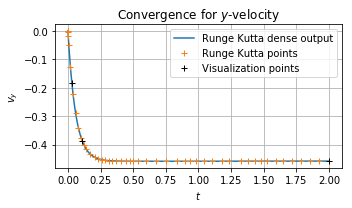

In [48]:
tt = np.linspace(sol.t[0], sol.t[-1], 10000)
Y = sol.sol(tt)
t_plot = np.array([0.03, 0.11, 2.0])

plt.figure(figsize=(5,3))
plt.plot(tt, Y[3,:], label='Runge Kutta dense output')
plt.plot(sol.t, sol.y[3,:], '+', label='Runge Kutta points')
plt.plot(t_plot, sol.sol(t_plot)[3,:], 'k+', label='Visualization points')
plt.xlabel("$t$")
plt.ylabel("$v_y$")
plt.title("Convergence for $y$-velocity")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("figures/q12_1.png", dpi=900)
plt.show()

print(sol.y[:,-1].__)

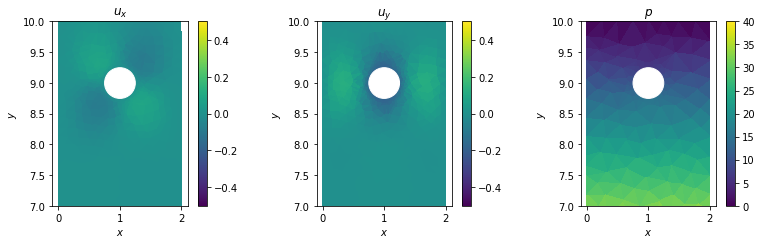

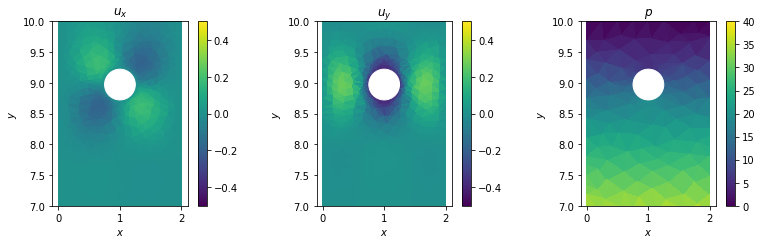

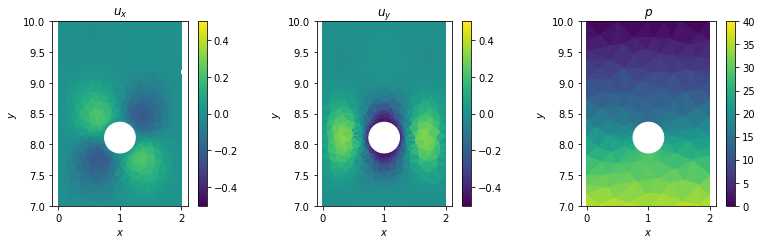

In [49]:
for i in range(t_plot.size):
    y = sol.sol(t_plot[i])
    fe_u, fe_p, u1_h, u2_h, p_h, Fb_x, Fb_y = fem_solve(y[0], y[1], y[2], y[3])
    min_u = -0.5
    max_u = 0.5
    shading='flat'
    
    fig = plt.figure(figsize=(11,3.5))
    ax = fig.add_subplot(1, 3, 1)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u1_h , shading=shading, vmin=min_u, vmax=max_u)
    circle1=plt.Circle((y[0],y[1]),.25,color='w')
    plt.gcf().gca().add_artist(circle1)
    ax.set_title("$u_x$")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.colorbar()
    ax.set_ylim([7,10])
    ax.set_aspect('equal')

    fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
    plt.tripcolor(fe_u['dof'][:,0], fe_u['dof'][:,1], u2_h, shading=shading, vmin=min_u, vmax=max_u)
    circle1=plt.Circle((y[0],y[1]),.25,color='w')
    plt.gcf().gca().add_artist(circle1)
    plt.title("$u_y$")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.colorbar()
    plt.gca().set_aspect('equal')

    fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
    plt.tripcolor(fe_p['dof'][:,0], fe_p['dof'][:,1], p_h,  shading=shading, vmin=0, vmax=40)
    circle1=plt.Circle((y[0],y[1]),.25,color='w')
    plt.gcf().gca().add_artist(circle1)
    plt.title("$p$")
    plt.xlabel("$x$")
    plt.ylabel("$y$")
    plt.colorbar()
    plt.gca().set_aspect('equal')

    plt.tight_layout()
    plt.savefig("figures/q12_{}.png".format(i+2), dpi=900)
    plt.show()

In [50]:
m = 1
y0 = sol.y[:,-1]
f_der = lambda x: fem_rhs(0, x, m=m, debug=False)

jac_ana = fem_jac(0, y0, m=m)
jac_num = approx_jac(y0, f_der, epsilon=0.01)
print(jac_ana)
print(jac_num)
print(jac_ana - jac_num)
print(np.amax(np.abs(jac_ana - jac_num)))

[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-0.00000000e+00 -0.00000000e+00 -1.06381767e+01  3.94059319e-03]
 [-0.00000000e+00 -0.00000000e+00  3.94059319e-03 -1.68671292e+01]]
[[ 0.00000000e+00  0.00000000e+00  1.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  1.00000000e+00]
 [-7.56879922e-02  9.26164969e-03 -1.06381767e+01  3.94059318e-03]
 [-6.51574480e-02 -2.01459617e-02  3.94059318e-03 -1.68671292e+01]]
[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00]
 [ 0.00000000e+00  0.00000000e+00  0.00000000e+00 -8.88178420e-16]
 [ 7.56879922e-02 -9.26164969e-03  1.68220993e-12  1.66298572e-12]
 [ 6.51574480e-02  2.01459617e-02  5.33387223e-12  8.10018719e-12]]
0.07568799219536682


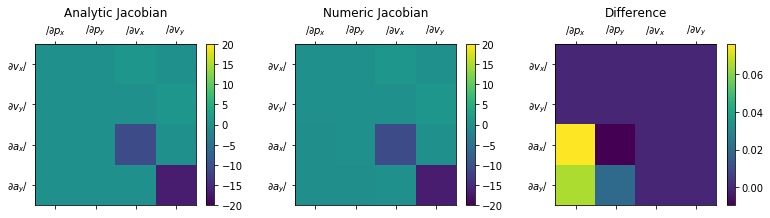

In [85]:
from matplotlib import rcParams
rcParams['axes.titlepad'] = 20 

fig = plt.figure(figsize=(11,3))
ax = fig.add_subplot(1, 3, 1)
cax = plt.gca().matshow(jac_ana, vmin=-20, vmax=20)
plt.colorbar(cax)
ax.set_aspect('equal')
plt.title("Analytic Jacobian")

ax.set_yticklabels(['', '$\partial v_x /$', '$\partial  v_y /$', '$\partial  a_x /$', '$\partial  a_y /$'])
ax.set_xticklabels(['', '$/ \partial p_x$', '$/ \partial p_y$', '$/ \partial v_x$', '$/ \partial v_y$'])

fig.add_subplot(1, 3, 2, sharex=ax, sharey=ax)
cax = plt.gca().matshow(jac_num, vmin=-20, vmax=20)
plt.colorbar(cax)
ax.set_aspect('equal')
plt.title("Numeric Jacobian")

fig.add_subplot(1, 3, 3, sharex=ax, sharey=ax)
cax = plt.gca().matshow(jac_ana-jac_num)
plt.colorbar(cax)
ax.set_aspect('equal')
plt.title("Difference")


plt.tight_layout()
plt.savefig("figures/q12_5.png", dpi=900)
plt.show()